## Test_setup

train.csv shape is  (1697533, 9)
test.csv shape is  (300000, 2)

   Id   ProductId          UserId  HelpfulnessNumerator  \
0   0  0005019281   ADZPIG9QOCDG5                     0   
1   1  0005019281  A35947ZP82G7JH                     0   
2   2  0005019281  A3UORV8A9D5L2E                     0   
3   3  0005019281  A1VKW06X1O2X7V                     0   
4   4  0005019281  A3R27T4HADWFFJ                     0   

   HelpfulnessDenominator  Score        Time  \
0                       0    4.0  1203984000   
1                       0    3.0  1388361600   
2                       0    3.0  1388361600   
3                       0    5.0  1202860800   
4                       0    4.0  1387670400   

                                        Summary  \
0                     good version of a classic   
1                        Good but not as moving   
2         Winkler's Performance was ok at best!   
3  It's an enjoyable twist on the classic story   
4                              Best 

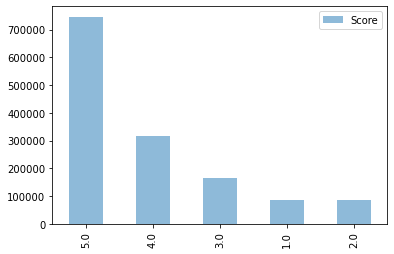


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

## Feature_extraction

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import scipy
from scipy.sparse import hstack

def process(df):
    # This is where you can do all your processing

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    df['Text'].fillna(value='Null', inplace=True)
    df['Summary'].fillna(value='Null', inplace=True)
    
    text_vectorizer = TfidfVectorizer(input='content', analyzer='word', stop_words='english', max_df=0.8, min_df=0.1)  #0.1~0.15
    summary_vectorizer = TfidfVectorizer(input='content', analyzer='word', stop_words='english', max_df=0.8, min_df=0.1)
    text_matrix = text_vectorizer.fit_transform(df['Text'])
    summary_matrix = summary_vectorizer.fit_transform(df['Summary'])
    
    scaler = StandardScaler()
    df[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness']] = scaler.fit_transform(df[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness']])
    numerical = scipy.sparse.csr_matrix(df[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness']].values)

    X = hstack([text_matrix, summary_matrix, numerical], format='csr')
    
    df = df.drop(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness'], axis=1)
    row_list = X.getrow(0)
    row_list = row_list.toarray()
    features_num = len(row_list.tolist()[0])
    for i in range(features_num):
        df["features"+str(i)] = ""
    samples_num = len(df)
    for i in range(samples_num):
        row_list = X.getrow(i)
        row_list = row_list.toarray()
        for j in range(features_num):
            df.at[i, "features"+str(j)] = row_list.tolist()[0][j] 
    return df


# Load the dataset
trainingSet = pd.read_csv("./data/train.csv")

# Process the DataFrame
train_processed = process(trainingSet)

# Load test set
submissionSet = pd.read_csv("./data/test.csv")

# Merge on Id so that the test set can have feature columns as well
testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
trainX =  train_processed[train_processed['Score'].notnull()]

testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)


In [24]:
trainX['features0'][0]

0.0

## Predict-knn

Accuracy on testing set =  0.5472574588418474


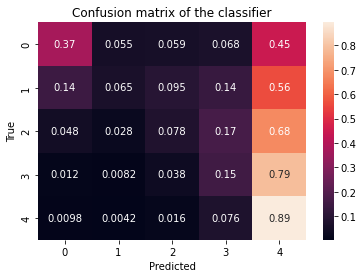

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
#from sklearn.linear_model import LogisticRegression

# Load files into DataFrames
X_train = pd.read_csv("./data/X_train.csv")
X_submission = pd.read_csv("./data/X_test.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )

# This is where you can do more feature selection
X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score'])

# Learn the model
#model = LogisticRegression(random_state = 0)
#model.fit(X_train_processed, Y_train)
model = KNeighborsClassifier(n_neighbors=20).fit(X_train_processed, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_processed)
X_submission['Score'] = model.predict(X_submission_processed)

# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create the submission file
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)
